In [1]:

# %pip install geopandas
# %pip install shapely
# %pip install pygeos
# %pip install tensorflow-cpu
# %pip install tensorflow-data-validation
# %pip install tensorflow-transform
# %pip install tensorflow-model-analysis
# %pip install scikit-learn
# %pip install scipy
# %pip install matplotlib
# %pip install python-dotenv
# %pip install seaborn

In [2]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sklearn as sk
import scipy as sp
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt
from shapely import wkt

f:\Programs\Miniconda3\envs\ml\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Red\AppData\Local\Temp\ipykernel_278532\2341453823.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.i

In [3]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('F:\\Uni Files\\4710\\4710 Project\\MLweatherForestFire')

In [4]:
def getGPDfromPD(df: pd.DataFrame, geomCol: str, crs: str = "EPSG:3978") -> gpd.GeoDataFrame:
    """
    Convert a pandas dataframe to a geopandas dataframe
    :param df: pandas dataframe
    :param geomCol: name of the geometry column
    :param crs: coordinate reference system
    :return: geopandas dataframe
    """
    if 'geom' in df.columns:
        df.rename(columns={'geom': 'geometry'}, inplace=True)

    df[geomCol] = df[geomCol].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry=geomCol, crs=crs)
    return gdf

In [5]:
provinces = "Data/GEOProvincialBoundaries.csv"
dfProvinces = pd.read_csv(provinces)
dfProvinces['geom'] = dfProvinces['geom'].apply(wkt.loads)
gdfProvinces = gpd.GeoDataFrame(dfProvinces, geometry='geom', crs="EPSG:3347")
del dfProvinces
del provinces

In [6]:
# Load fire data
fireTable = "Data/GEOSKFireWaterElev.csv"
dfFire = pd.read_csv(fireTable)
dfFire['geom'] = dfFire['geom'].apply(wkt.loads)
gdfFire = gpd.GeoDataFrame(dfFire, geometry='geom', crs="EPSG:3347")
del dfFire
del fireTable

<AxesSubplot: >

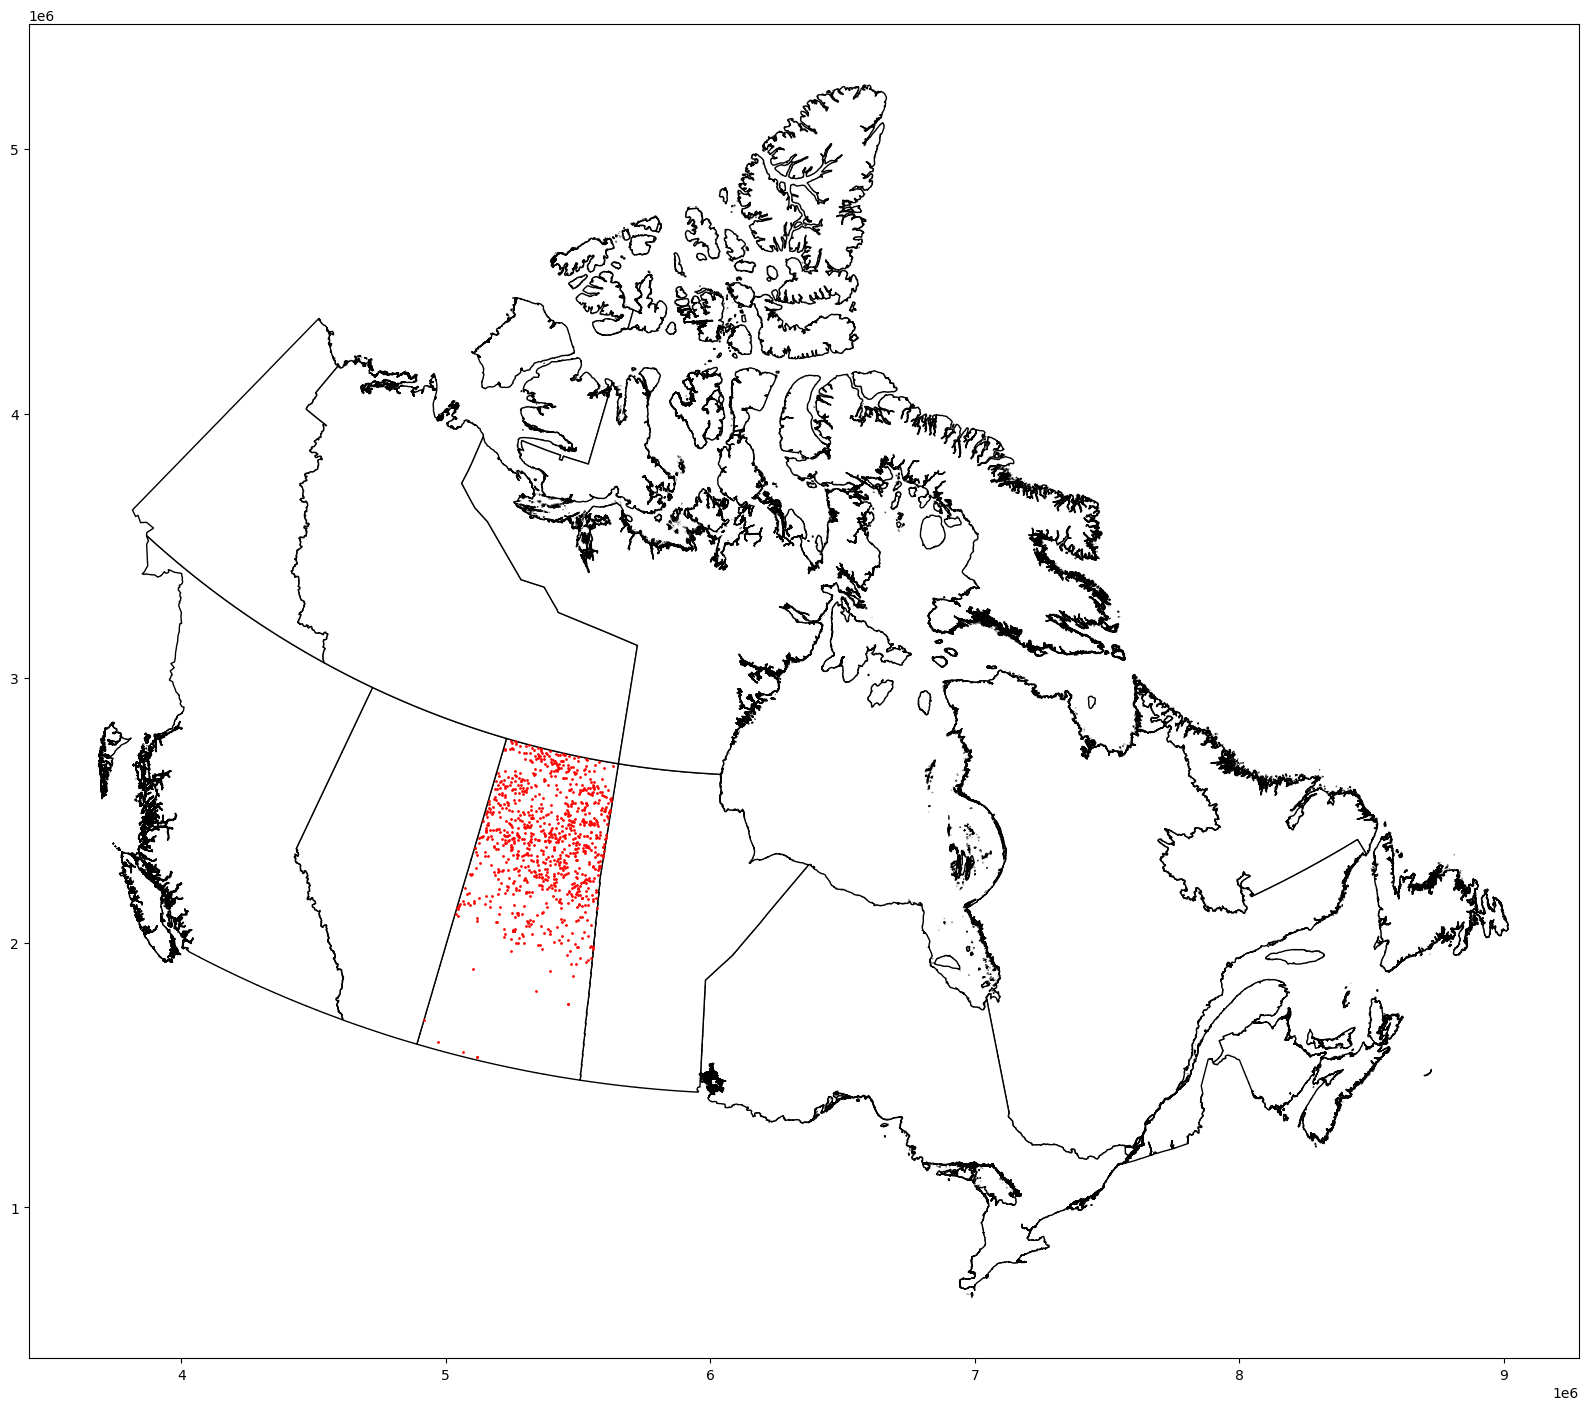

In [7]:
##### plot both to check
fig, ax = plt.subplots(figsize=(20, 20))
gdfProvinces.plot(ax=ax, color='white', edgecolor='black')
gdfFire.plot(ax=ax, color='red', markersize=1)


##### plot both to check
fig, ax = plt.subplots(figsize=(20, 20))
gdfProvinces.plot(ax=ax, color='white', edgecolor='black')
gdfCentroids.plot(ax=ax, color='red', markersize=1)


# plot to check
f1, ax1 = plt.subplots(figsize=(19.20, 10.80))
dfProv.boundary.plot(ax=ax1, color=None, edgecolor='black', linewidth=1, aspect=1)
dfWater.plot(ax=ax1, color='red', markersize=0.1, aspect=1)


In [9]:
dailyWeather = "Data/WeatherDataHourlyAggDaily.csv"
dfWeather = pd.read_csv(dailyWeather)
dfWeather.columns

C:\Users\Red\AppData\Local\Temp\ipykernel_278532\2291072772.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfWeather = pd.read_csv(dailyWeather)


Index(['ClimateID', 'ProvinceCode', 'Year', 'Month', 'Day', 'MeanTemp',
       'MinTemp', 'MaxTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
       'MeanHumidity', 'MinHumidity', 'MaxHumidity', 'MeanPressure',
       'MinPressure', 'MaxPressure', 'MeanWindSpeed', 'MinWindSpeed',
       'MaxWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
       'TotalPrecip', 'MeanWindDirection'],
      dtype='object')

In [10]:
dfWeather.astype({'ClimateID': 'str', 'ProvinceCode': 'str', 
                'Year': 'int', 'Month': 'int', 'Day': 'int',
                'MeanTemp': 'float', 'MinTemp': 'float', 'MaxTemp': 'float',
                'MeanDewPoint': 'float', 'MinDewPoint': 'float', 'MaxDewPoint': 'float',
                'MeanHumidity': 'float', 'MinHumidity': 'float', 'MaxHumidity': 'float',
                'MeanPressure': 'float', 'MinPressure': 'float', 'MaxPressure': 'float',
                'MeanWindSpeed': 'float', 'MinWindSpeed': 'float', 'MaxWindSpeed': 'float',
                'MeanWindChill': 'float', 'MinWindChill': 'float', 'MaxWindChill': 'float',
                'TotalPrecip': 'float', 'MeanWindDirection': 'float'}, copy=False)
dfWeather.drop(columns=['MeanTemp', 'MinTemp', 'MeanDewPoint', 'MinDewPoint', 'MaxDewPoint',
                    'MinHumidity', 'MaxHumidity', 'MeanPressure', 'MinPressure',
                    'MaxPressure', 'MinWindSpeed', 'MeanWindChill', 'MinWindChill', 'MaxWindChill',
                    'MeanWindDirection' ], inplace=True)

In [11]:
stations = "Data/climate_station_list.csv"
dfAllStations = pd.read_csv(stations)
wantedStations = pd.DataFrame(dfWeather['ClimateID'].unique().astype(str))
wantedStations.columns = ["Climate ID"]

In [12]:
dfAllStations.astype({'Climate ID': 'str'}, copy=False)
dfStations = wantedStations.merge(dfAllStations, on=['Climate ID'], how='left')
dfStations.head()

,Climate ID,Station Name,Province,Latitude,Longitude,Elevation,WMO Identifier,TC Identifier,First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
0,2202200,FORT SMITH A,NORTHWEST TERRITORIES,60.0,-112.0,205.1,71934.0,YSM,1943,2014,1953.0,2014.0,1943.0,2014.0,1943.0,2014.0
1,4061629,COLLINS BAY,SASKATCHEWAN,58.2,-103.7,490.1,NaN,NaN,1992,2018,1994.0,2015.0,1992.0,2018.0,1996.0,2007.0
2,2202202,FORT SMITH CLIMATE,NORTHWEST TERRITORIES,60.0,-111.9,203.0,71362.0,ZSM,2003,2022,2003.0,2022.0,2003.0,2022.0,2003.0,2007.0
3,2202201,FORT SMITH A,NORTHWEST TERRITORIES,60.0,-112.0,205.1,71934.0,YSM,2014,2022,2014.0,2022.0,2014.0,2022.0,NaN,NaN
4,4060983,BUFFALO NARROWS (AUT),SASKATCHEWAN,55.8,-108.4,440.1,71077.0,WVT,1992,2022,1994.0,2022.0,1992.0,2022.0,1998.0,2007.0


In [13]:
dfStations

,Climate ID,Station Name,Province,Latitude,Longitude,Elevation,WMO Identifier,TC Identifier,First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year
0,2202200,FORT SMITH A,NORTHWEST TERRITORIES,60.0,-112.0,205.1,71934.0,YSM,1943,2014,1953.0,2014.0,1943.0,2014.0,1943.0,2014.0
1,4061629,COLLINS BAY,SASKATCHEWAN,58.2,-103.7,490.1,NaN,NaN,1992,2018,1994.0,2015.0,1992.0,2018.0,1996.0,2007.0
2,2202202,FORT SMITH CLIMATE,NORTHWEST TERRITORIES,60.0,-111.9,203.0,71362.0,ZSM,2003,2022,2003.0,2022.0,2003.0,2022.0,2003.0,2007.0
3,2202201,FORT SMITH A,NORTHWEST TERRITORIES,60.0,-112.0,205.1,71934.0,YSM,2014,2022,2014.0,2022.0,2014.0,2022.0,NaN,NaN
4,4060983,BUFFALO NARROWS (AUT),SASKATCHEWAN,55.8,-108.4,440.1,71077.0,WVT,1992,2022,1994.0,2022.0,1992.0,2022.0,1998.0,2007.0
5,2202203,FORT SMITH A,NORTHWEST TERRITORIES,60.0,-112.0,205.1,NaN,YSM,2016,2022,2016.0,2022.0,2018.0,2022.0,NaN,NaN
6,4060982,BUFFALO NARROWS A,SASKATCHEWAN,55.8,-108.4,433.7,71077.0,YVT,1979,2012,1979.0,2012.0,1979.0,2012.0,1979.0,2007.0
7,4060988,BUFFALO NARROWS A,SASKATCHEWAN,55.8,-108.4,433.7,NaN,YVT,2014,2022,2014.0,2022.0,2018.0,2022.0,NaN,NaN
8,4060984,BUFFALO NARROWS A,SASKATCHEWAN,55.8,-108.4,433.7,NaN,YVT,2012,2019,2012.0,2019.0,NaN,NaN,NaN,NaN
9,4061620,COLLINS BAY SK,SASKATCHEWAN,58.2,-103.7,412.6,71075.0,WWC,2015,2022,2015.0,2022.0,2016.0,2022.0,NaN,NaN


In [14]:

gdfStations = gpd.GeoDataFrame(dfStations, geometry=gpd.points_from_xy(dfStations['Longitude'], dfStations['Latitude']), crs="EPSG:4326")

In [15]:
gdfStations.drop(columns={'DLY First Year', 'DLY Last Year', 'MLY First Year', 'MLY Last Year', 'WMO Identifier', 'TC Identifier', 'Station Name', 'Province', 'Latitude', 'Longitude', 'Elevation'}, inplace=True)

In [16]:
gdfStations = gdfStations[gdfStations['HLY First Year'] < 2000]
gdfStations = gdfStations[gdfStations['HLY Last Year'] == 2022]


In [17]:
gdfStations = gdfStations.to_crs("EPSG:3347")

In [18]:
gdfFire.drop(columns={'index_right', 'provID'}, inplace=True)
gdfFire.count()

EntryID          937
FIRE_ID          937
FIRENAME         937
YEAR             937
MONTH            937
DAY              937
REP_DATE         937
SIZE_HA          937
size_ha_bin      937
geom             937
ElevationM       937
Dist_To_Water    937
dtype: int64

<AxesSubplot: >

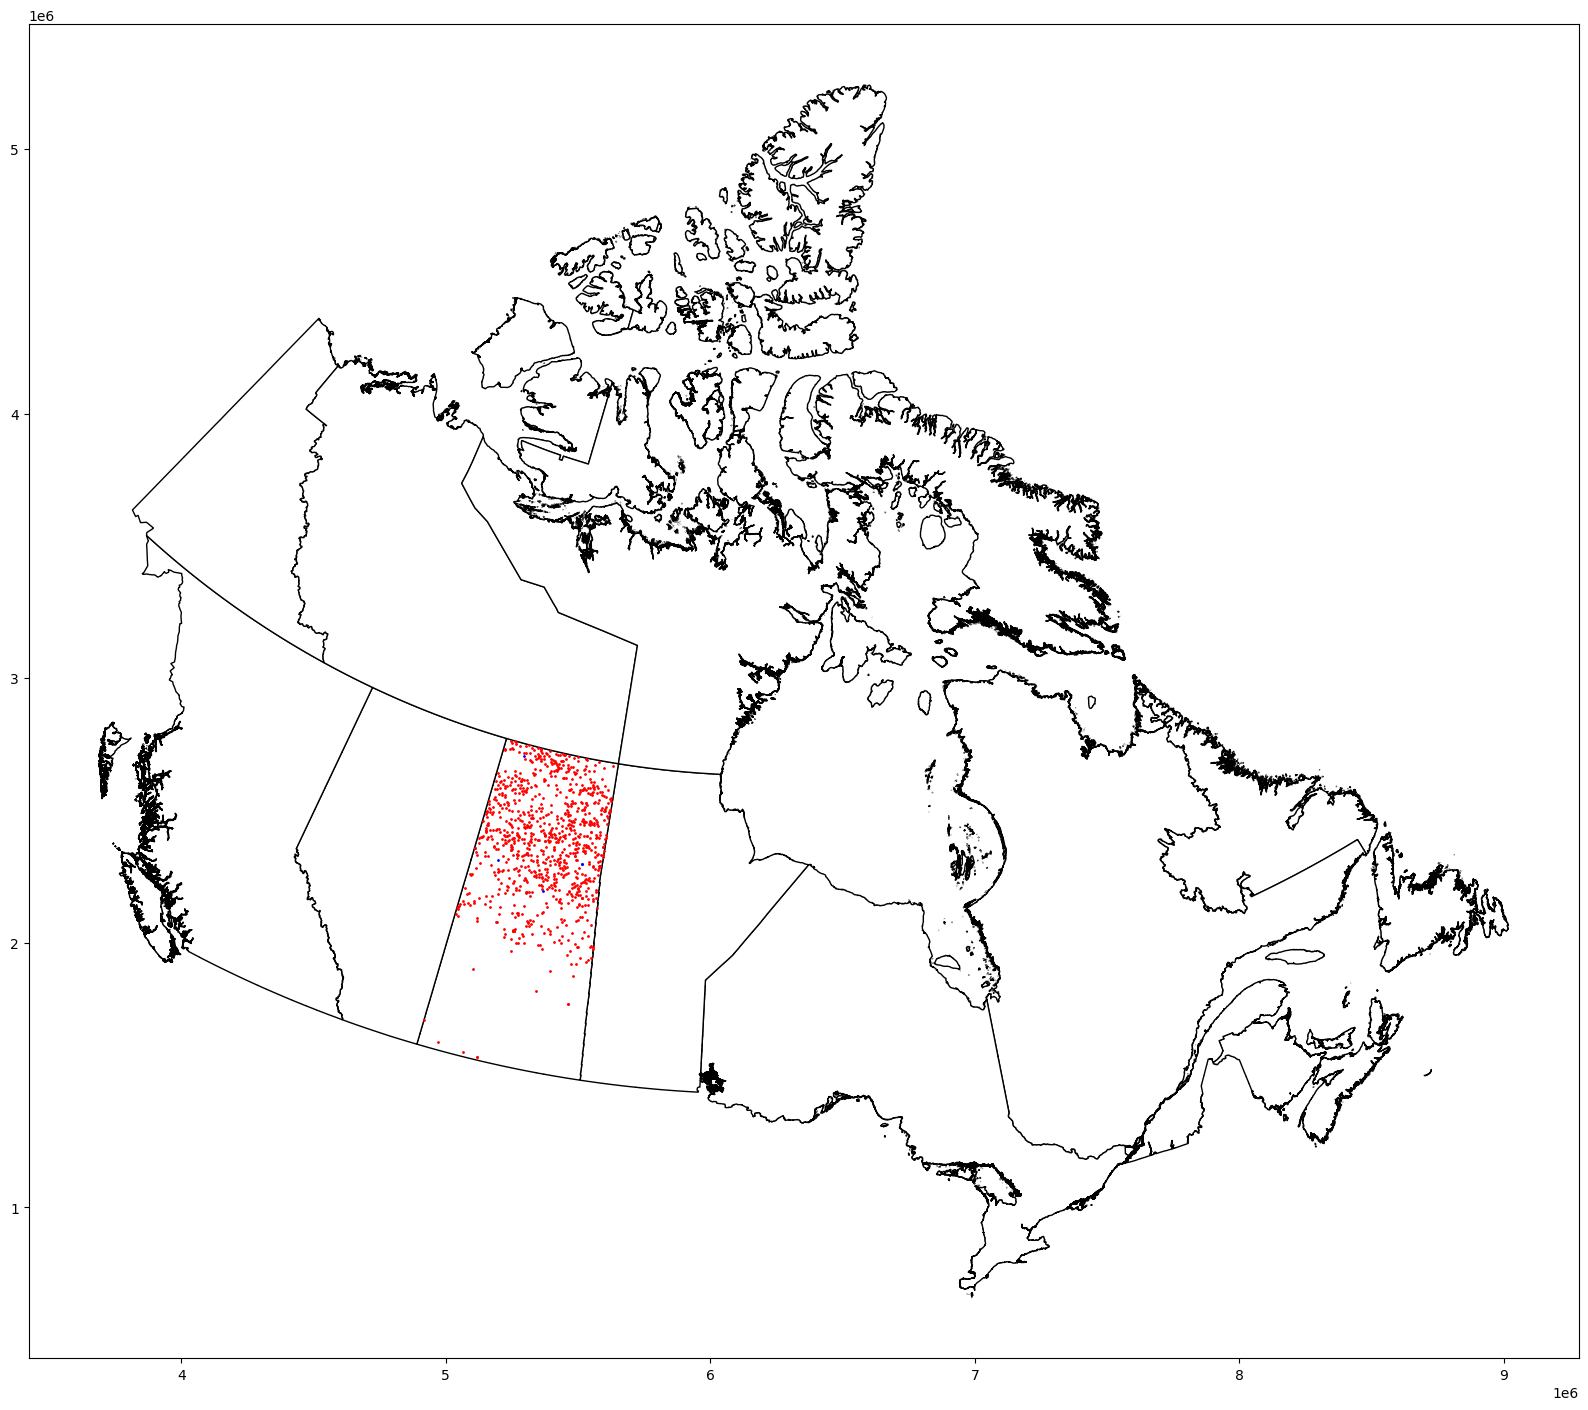

In [19]:
##### plot both to check
fig, ax = plt.subplots(figsize=(20, 20))
gdfProvinces.plot(ax=ax, color='white', edgecolor='black')
gdfFire.plot(ax=ax, color='red', markersize=1)
gdfStations.plot(ax=ax, color='blue', markersize=1)

In [20]:

# gpd sjoin to find nearest station to each fire
gdfNearest = gpd.sjoin_nearest(gdfFire, gdfStations, how="left", max_distance=1000000, distance_col='distance')
print(gdfNearest.count())
print(gdfNearest.columns)
print(gdfNearest.head()) 
gdfNearest.drop(columns={'index_right', 'First Year', 'Last Year',
       'HLY First Year', 'HLY Last Year'}, inplace=True)

EntryID           1245
FIRE_ID           1245
FIRENAME          1245
YEAR              1245
MONTH             1245
DAY               1245
REP_DATE          1245
SIZE_HA           1245
size_ha_bin       1245
geom              1245
ElevationM        1245
Dist_To_Water     1245
index_right       1245
Climate ID        1245
First Year        1245
Last Year         1245
HLY First Year    1245
HLY Last Year     1245
distance          1245
dtype: int64
Index(['EntryID', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'SIZE_HA', 'size_ha_bin', 'geom', 'ElevationM', 'Dist_To_Water',
       'index_right', 'Climate ID', 'First Year', 'Last Year',
       'HLY First Year', 'HLY Last Year', 'distance'],
      dtype='object')
   EntryID FIRE_ID       FIRENAME  YEAR  MONTH  DAY    REP_DATE  SIZE_HA  \
0      631  L81022    08LA-SIMMER  2008      6    6  2008-06-06  34665.8   
1      638  L83027     08SE-ROCKY  2008      6   22  2008-06-22    245.9   
1      638  L83027     08SE-ROCKY

In [21]:
# drop rows with nan values
gdfNearest.dropna(inplace=True)
print(gdfNearest.count())
print(gdfNearest.columns)
print(gdfNearest.head()) 


EntryID          1245
FIRE_ID          1245
FIRENAME         1245
YEAR             1245
MONTH            1245
DAY              1245
REP_DATE         1245
SIZE_HA          1245
size_ha_bin      1245
geom             1245
ElevationM       1245
Dist_To_Water    1245
Climate ID       1245
distance         1245
dtype: int64
Index(['EntryID', 'FIRE_ID', 'FIRENAME', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'SIZE_HA', 'size_ha_bin', 'geom', 'ElevationM', 'Dist_To_Water',
       'Climate ID', 'distance'],
      dtype='object')
   EntryID FIRE_ID       FIRENAME  YEAR  MONTH  DAY    REP_DATE  SIZE_HA  \
0      631  L81022    08LA-SIMMER  2008      6    6  2008-06-06  34665.8   
1      638  L83027     08SE-ROCKY  2008      6   22  2008-06-22    245.9   
1      638  L83027     08SE-ROCKY  2008      6   22  2008-06-22    245.9   
2      639  L83020  08SE-MARGARET  2008      6    5  2008-06-05   4420.9   
2      639  L83020  08SE-MARGARET  2008      6    5  2008-06-05   4420.9   

   size_ha_bin   

In [22]:
# keep only the row with the smallest distance for each entryid
gdfNearest = gdfNearest.sort_values(by=['EntryID','distance'])
gdfNearest = gdfNearest.drop_duplicates(subset=['EntryID'], keep='first')
print(gdfNearest.count())

EntryID          937
FIRE_ID          937
FIRENAME         937
YEAR             937
MONTH            937
DAY              937
REP_DATE         937
SIZE_HA          937
size_ha_bin      937
geom             937
ElevationM       937
Dist_To_Water    937
Climate ID       937
distance         937
dtype: int64


In [23]:
# save to csv GEOSKFFWENearestStation.csv
gdfNearest.to_csv('Data/GEOSKFFWENearestStation.csv', index=False)